In [1]:
# Cervical Cancer Risk Prediction - Automated Machine Learning Pipeline
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Data Loading and Initial Exploration
# Import the csv file
cancer_df = pd.read_csv('./data/risk_factors_cervical_cancer.csv')

# Replace '?' with NaN
cancer_df = cancer_df.replace('?', np.nan)

# Convert all columns to numeric type
cancer_df = cancer_df.apply(pd.to_numeric)

# Drop columns with more than 80% missing values
missing_threshold = 0.8
cancer_df = cancer_df.dropna(thresh=missing_threshold * len(cancer_df), axis=1)

# Impute remaining missing values with the mean
cancer_df.fillna(cancer_df.mean(), inplace=True)

In [3]:
# 2. Automated Feature Selection
# Calculate the absolute correlation of features with the target variable
abs_corr_with_target = cancer_df.corr()['Biopsy'].abs().sort_values(ascending=False)

# Keep features with absolute correlation greater than a threshold
correlation_threshold = 0.05
features_to_keep = abs_corr_with_target[abs_corr_with_target >= correlation_threshold].index
cancer_df = cancer_df[features_to_keep]

# Separate target and features
target_df = cancer_df['Biopsy']
input_df = cancer_df.drop(columns=['Biopsy'])

# Convert to numpy arrays
X = np.array(input_df).astype('float32')
y = np.array(target_df).astype('float32').reshape(-1, 1)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [4]:
# 3. Automated Model Training and Evaluation
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    """Evaluate a model and return performance metrics"""
    # Train the model
    start_time = time.time()
    model.fit(X_train, Y_train.ravel())
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Calculate ROC AUC if the model has predict_proba
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(Y_test, y_pred_proba)
    except:
        roc_auc = None
    
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'y_pred': y_pred
    }

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier()
}

# Evaluate all baseline models
baseline_results = []

for name, model in models.items():
    print(f"Training {name}...")
    result = evaluate_model(model, X_train, X_val, Y_train, Y_val)
    result['model'] = name
    baseline_results.append(result)
    print(f"{name} - Accuracy: {result['accuracy']:.4f}, F1: {result['f1_score']:.4f}")

# Select the best baseline model
best_baseline_model = max(baseline_results, key=lambda x: x['f1_score'])
print(f"\nBest Baseline Model: {best_baseline_model['model']} with F1 Score: {best_baseline_model['f1_score']:.4f}")

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9535, F1: 0.5714
Training Random Forest...
Random Forest - Accuracy: 0.9612, F1: 0.6154
Training SVM...
SVM - Accuracy: 0.9535, F1: 0.4000
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9612, F1: 0.6667
Training XGBoost...
XGBoost - Accuracy: 0.9612, F1: 0.6667
Training Neural Network...
Neural Network - Accuracy: 0.9612, F1: 0.6154
Training KNN...
KNN - Accuracy: 0.9612, F1: 0.5455

Best Baseline Model: Gradient Boosting with F1 Score: 0.6667


In [5]:
# 4. Automated Hyperparameter Tuning
# Define hyperparameter grids for tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan, 2: Euclidean
    }
}

# Perform hyperparameter tuning for the top 3 models
tuned_models = {}
for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    grid_search = RandomizedSearchCV(
        model,
        param_grids[model_name],
        cv=5,
        n_jobs=-1,
        scoring='f1',
        n_iter=20,
        random_state=42
    )
    grid_search.fit(X_train, Y_train.ravel())
    tuned_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")


Tuning Logistic Regression...
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Best F1 score: 0.7600

Tuning Random Forest...
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best F1 score: 0.7148

Tuning SVM...
Best parameters for SVM: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best F1 score: 0.6664

Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.2}
Best F1 score: 0.6090

Tuning XGBoost...
Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best F1 score: 0.6544

Tuning Neural Network...
Best parameters for Neural Network: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}
Best F1 score: 0.5507

Tuning KNN...
Best paramet

In [6]:
# 5. Evaluate Tuned Models
tuned_results = []
for name, model in tuned_models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train, X_val, Y_train, Y_val)
    result['model'] = name
    tuned_results.append(result)
    print(f"{name} - Accuracy: {result['accuracy']:.4f}, F1: {result['f1_score']:.4f}")

# Select the best model overall
final_results = baseline_results + tuned_results
best_model_result = max(final_results, key=lambda x: x['f1_score'])
best_model_name = best_model_result['model']
best_model = tuned_models.get(best_model_name, models[best_model_name])

print(f"\nBest Model Overall: {best_model_name} with F1 Score: {best_model_result['f1_score']:.4f}")

Evaluating Logistic Regression...
Logistic Regression - Accuracy: 0.9690, F1: 0.7500
Evaluating Random Forest...
Random Forest - Accuracy: 0.9690, F1: 0.7143
Evaluating SVM...
SVM - Accuracy: 0.9690, F1: 0.7500
Evaluating Gradient Boosting...
Gradient Boosting - Accuracy: 0.9690, F1: 0.7143
Evaluating XGBoost...
XGBoost - Accuracy: 0.9767, F1: 0.8000
Evaluating Neural Network...
Neural Network - Accuracy: 0.9535, F1: 0.4000
Evaluating KNN...
KNN - Accuracy: 0.9612, F1: 0.5455

Best Model Overall: XGBoost with F1 Score: 0.8000


In [7]:
# 6. Save the Best Model and Artifacts
import os
os.makedirs('model_artifacts', exist_ok=True)

# Save the best model
model_filename = f'model_artifacts/cervical_cancer_best_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nBest model saved to: {model_filename}")

# Save the scaler
scaler_filename = 'model_artifacts/cervical_cancer_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to: {scaler_filename}")

# Save feature names
feature_names_filename = 'model_artifacts/feature_names.joblib'
joblib.dump(list(input_df.columns), feature_names_filename)
print(f"Feature names saved to: {feature_names_filename}")


Best model saved to: model_artifacts/cervical_cancer_best_model.joblib
Scaler saved to: model_artifacts/cervical_cancer_scaler.joblib
Feature names saved to: model_artifacts/feature_names.joblib


Training final model on 729 samples...

Final Test Set Evaluation:
Model: XGBoost
Test Accuracy: 0.9612
Test Precision: 0.7143
Test Recall: 0.6250
Test F1 Score: 0.6667


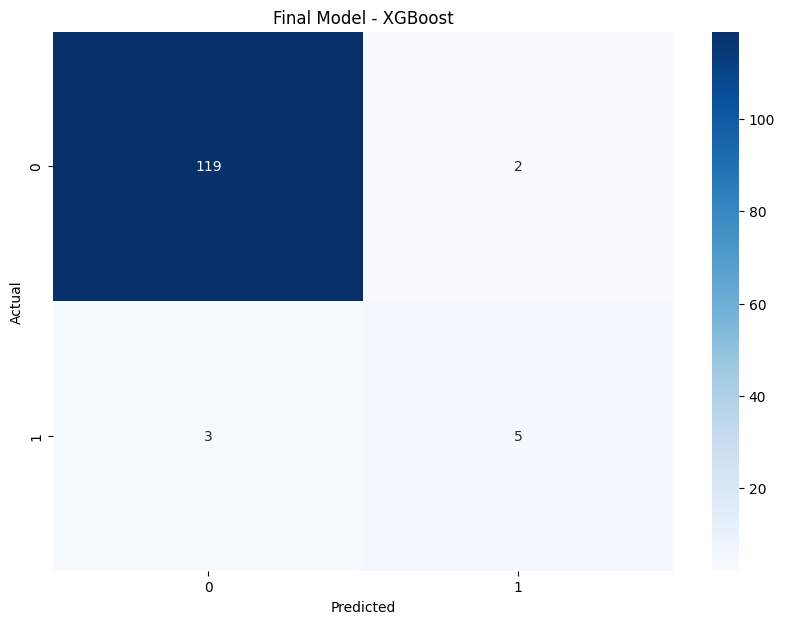


Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       121
         1.0       0.71      0.62      0.67         8

    accuracy                           0.96       129
   macro avg       0.84      0.80      0.82       129
weighted avg       0.96      0.96      0.96       129



In [8]:
# 7. Final Evaluation on Test Set
# Fit the best model on the combined training and validation data
X_train_full = np.vstack((X_train, X_val))
Y_train_full = np.vstack((Y_train, Y_val))

print(f"Training final model on {X_train_full.shape[0]} samples...")
best_model.fit(X_train_full, Y_train_full.ravel())

# Make predictions on test set
test_predictions = best_model.predict(X_test)

# Calculate final metrics
final_accuracy = accuracy_score(Y_test, test_predictions)
final_precision = precision_score(Y_test, test_predictions)
final_recall = recall_score(Y_test, test_predictions)
final_f1 = f1_score(Y_test, test_predictions)

print("\nFinal Test Set Evaluation:")
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Test Precision: {final_precision:.4f}")
print(f"Test Recall: {final_recall:.4f}")
print(f"Test F1 Score: {final_f1:.4f}")

# Define plot_confusion_matrix function
def plot_confusion_matrix(y_true, y_pred, title):
	cm = confusion_matrix(y_true, y_pred)
	plt.figure(figsize=(10, 7))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
	plt.title(title)
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.show()

# Plot final confusion matrix
plot_confusion_matrix(Y_test, test_predictions, f"Final Model - {best_model_name}")

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(Y_test, test_predictions))

In [9]:
# 8. Summary and Conclusions
print("\n=== Cervical Cancer Risk Prediction Model Summary ===")
print(f"Best model: {best_model_name}")
print(f"Test set accuracy: {final_accuracy:.4f}")
print(f"Test set F1 score: {final_f1:.4f}")
print(f"Test set precision: {final_precision:.4f}")
print(f"Test set recall: {final_recall:.4f}")


=== Cervical Cancer Risk Prediction Model Summary ===
Best model: XGBoost
Test set accuracy: 0.9612
Test set F1 score: 0.6667
Test set precision: 0.7143
Test set recall: 0.6250


In [10]:
# End of notebook
print("\nNotebook completed successfully!")


Notebook completed successfully!
